In [ ]:
! pip install -U jax jaxlib flax optax


In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

<Axes: >

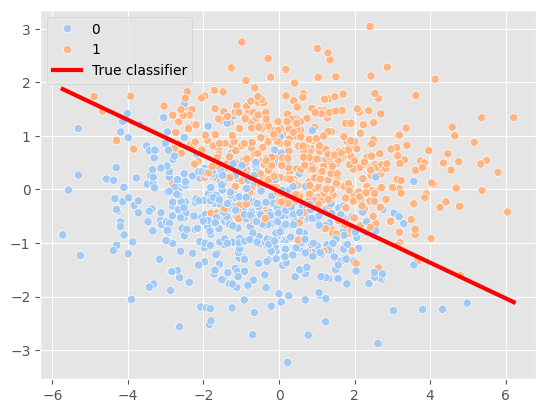

In [ ]:
# Line parameters
# Multiplying the weights with a scalar will change randomness keeping the boundary constant
w1, w2, b = (1,3,0.1)

def get_y(x, w1, w2, b):
  return -(w1*x + b)/w2
def get_distance(x, y):
  """Finds distance of point (x,y)  from line $w1 *x +w2 * y + b$"""
  return (w1 * x+ w2*y +b) #/ np.linalg.norm([w1, w2]) - intentionally not normalizing as the model does the same.
def sigmoid(x):
  return 1/(1 + np.exp(-x))
def positive_prob(distance):
  """Applies sigmoid to the distance.

  Args:
    distance: Distance of point from the line.
              Distance 0 will be 50-50 probability.
              Positive distance will result in p >0.5
  """
  p= sigmoid(distance)
  return float(format(p,".2f"))
def get_class(positive_prob):
  """Samples labels based on probability.

    Args:
      positive_prob: probability that label is 1
  """
  return np.random.choice([1,0], size = None, p = [positive_prob,1-positive_prob])

# Random dataset sampled from a gaussian distribution.
x = np.random.normal(0,2, size = (1000,))
y = np.random.normal(0,1, size = (1000,))

df = pd.DataFrame({'x': x,'y':y})

df['distance'] = df.apply(lambda row: get_distance(row.x, row.y), axis = 1)
df['label'] = df.distance.apply( lambda d: get_class(positive_prob(d)))

# couple of points on the line needed to plot.
online_x = np.array([x.min(), x.max()])
online_y = get_y(online_x, w1, w2, b)

sns.scatterplot(df, x= x, y = y, hue = 'label', palette = 'pastel')
sns.lineplot(x= online_x, y = online_y, color = 'red', linewidth = 3, label = 'True classifier')

In [ ]:
class LogisticRegressionModel(nn.Module):
  @nn.compact
  def __call__(self, x, y):
    w1 = self.param('w1', init_fn = lambda key: jax.random.normal(key))
    w2 = self.param('w2', init_fn = lambda key: jax.random.normal(key))
    b = self.param('b', init_fn = lambda key: 0.0)

    return w1 * x + w2 * y + b

# model = LogisticRegressionModel()
# params = model.init(jax.random.PRNGKey(42), x,y)
# print(params)
# model.apply(params, x = 1, y = 1)

In [ ]:
def loss(params, apply_fn, x, y, label):
  """Binary cross entropy."""
  logit = apply_fn(params, x, y)
  return optax.sigmoid_binary_cross_entropy(logit, label)
assert optax.sigmoid_binary_cross_entropy(-1.0,1) > optax.sigmoid_binary_cross_entropy(1.0,1)

AttributeError: 'float' object has no attribute 'dtype'

In [ ]:
value_and_grad = jax.value_and_grad(loss)
value_and_grad_vectorized = jax.vmap(value_and_grad, in_axes = (jax.tree_util.tree_map(lambda x: None, params),None, 0,0,0 ))
# loss, grad = value_and_grad_vectorized(params, model.apply, np.array([0,1.]), np.array([0,1.]), np.array([0,0]))
# print(f'elementwise losses = {loss}\nelement_wise_grad = {grad}')

In [ ]:
optimizer = optax.sgd(learning_rate = 0.1)
optimizer_state = optimizer.init(params)

def update_weights(params, optimizer_state, x, y, label,  apply_fn, optimizer):
  loss, grad = value_and_grad_vectorized(params, apply_fn, x, y, label)
  loss = jnp.mean(loss)
  grad = jax.tree_util.tree_map(jnp.mean, grad)
  weight_updates, new_states =  optimizer.update(grad, optimizer_state)
  new_params = optax.apply_updates(params, weight_updates)
  return new_params, new_states , loss
# update_weights(params, optimizer_state, df.x.head(2).values,  df.y.head(2).values,  df.label.head(2).values,
#                model.apply, optimizer)

In [ ]:
def accuracy(y_true, y_pred):
  return jnp.mean(y_true == y_pred)
# accuracy(np.array([0,1]),np.array([1,1]))

In [ ]:
model = LogisticRegressionModel()
params = model.init(jax.random.PRNGKey(10), x = 1, y = 0.0)
print(f'Initial params : {params}')
optimizer = optax.sgd(learning_rate = 0.3)
optimizer_state = optimizer.init(params)

def train_epoch(params, optimizer_state):
  new_params, new_states, loss = update_weights(params,
                                          optimizer_state,
                                          df.x.values,
                                          df.y.values,
                                          df.label.values,
                                          model.apply,
                                          optimizer)
  logits = model.apply(new_params, df.x.values, df.y.values)
  positive = jnp.array(logits)>0.5
  preds = jnp.array(positive, dtype = int)
  acc = accuracy(df.label.values, preds)
  return new_params, new_states, loss, acc
# train_epoch(params, optimizer_state)


In [ ]:
Initial params : FrozenDict({
    params: {
        w1: Array(0.32724857, dtype=float32),
        w2: Array(-1.1509773, dtype=float32),
        b: 0.0,
    },
})

In [ ]:
def plot_result(ax, params, epoch, accuracy, loss):
  p = params['params']
  online_x = np.array([x.min(), x.max()])
  original_y = get_y(online_x, w1,w2,b)

  #Fetch points to plot prediciton boundary based on params.
  w1_n,w2_n,b_n = p['w1'], p['w2'], p['b']
  new_y = get_y(online_x, w1_n, w2_n, b_n)

  sns.scatterplot(df, x= x, y = y, hue = 'label', palette = 'pastel', ax = ax)
  sns.lineplot(x= online_x, y = original_y, color = 'green', linewidth = 3, label='True classifier', ax = ax)
  sns.lineplot(x= online_x, y = new_y, color = 'red', linewidth = 3, label='Predicted classifier', alpha = 0.5, ax = ax)
  ax.legend(fontsize = 7)
  ax.set_title(f'Epoch: {epoch} : accuracy: {accuracy:.2f}, loss:{loss:.2f}, w1:{w1_n:.2f}, w2:{w2_n:.2f}, b:{b_n:.2f}', fontsize = 10)
fig, ax = plt.subplots(1,1,)
plot_result(ax, params, 0,0,0)
ax.set_title('Before Training')


In [ ]:
from tqdm.auto import trange
epochs = 100

fig, axes = plt.subplots(5,2, figsize = (10,15))
axes = axes.flatten()
for epoch in trange(1, epochs+1):
  params, optimizer_states, loss, acc = train_epoch(params, optimizer_state)
  if epoch % 10 == 0:
    plot_result(axes[epoch//10-1], params, epoch, acc, loss)
plt.tight_layout()